# Regresión lineal con Python - Laboratorio Electricidad y Magnetismo
En este documento se obtendrá el valor de la resistencia encontrada a partir del voltaje que se aplica sobre ella y la corriente que pasa por ella. Siendo la resistencia equivalente a la pendiente de la gráfica I vs V
Para ello tenemos diversos voltajes medidos en laboratorio con su respectiva corriente asociada. De estos puntos es necesario encontrar la ecuación líneal que mejor se asocie, para asi encontrar su pendiente y compararla con el valor teórico de la resistencia.
En la primera parte del laboratorio se realizaron pruebas de medición de corriente en un circuito con un voltaje aplicado y una única resistencia.
En la segunda parte se realizaron de igual manera pruebas de medición de corriente sin embargo en circuitos con múltiples resistencias, en serie, paralelo, o mixtas.

In [30]:
import copy, math
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
np.set_printoptions(precision=2)

In [31]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)

In [32]:
resistencias_teoricas = [8.2, 3.3, 6.8, 4.7]
voltajes = [
  np.array([1, 2, 3, 4, 8, 10, 12, 15]),
  np.array([1, 2, 3, 4, 6, 8, 10, 12, 15]),
  np.array([1, 2, 3, 4, 6, 8, 10, 12, 15]),
  np.array([1, 2, 3, 4, 6, 8, 10, 12, 15])
]
corrientes = [
  np.array([0.12, 0.32, 0.38, 0.50, 0.98, 1.16, 1.34, 1.81]),
  np.array([0.71, 0.84, 1.34, 1.78, 3.00, 3.58, 4.54, 5.52, 6.82]),
  np.array([0.22, 0.30, 0.51, 0.65, 0.87, 1.24, 1.48, 1.85, 2.25]),
  np.array([0.25, 0.45, 0.60, 0.95, 1.24, 1.69, 2.21, 2.55, 3.17]),
]
# corrientes = []
# voltajes = []
# for i in range(len(corrientes_sin_normalizar)):
#     X_norm, mu_x, sigma_x = zscore_normalize_features(corrientes_sin_normalizar[i])
#     Y_norm, mu_y, sigma_y = zscore_normalize_features(corrientes_sin_normalizar[i])
#     corrientes.append(X_norm)
#     voltajes.append(Y_norm)

In [33]:
# data is stored in numpy array/matrix
print(f"X Shape: {voltajes[0].shape}, X Type:{type(voltajes[0])})")
print(voltajes[0])
print(f"y Shape: {corrientes[0].shape}, y Type:{type(corrientes[0])})")
print(corrientes[0])

X Shape: (8,), X Type:<class 'numpy.ndarray'>)
[ 1  2  3  4  8 10 12 15]
y Shape: (8,), y Type:<class 'numpy.ndarray'>)
[0.12 0.32 0.38 0.5  0.98 1.16 1.34 1.81]


In [34]:
def compute_cost(X, y, w, b):
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b
        cost = cost + (f_wb_i - y[i])**2
    cost = cost / (2*m)

    return cost


In [35]:
# Ejemplo
w_example = 10
b_example = 0
cost = compute_cost(voltajes[0], corrientes[0], w_example, b_example)
print(f'Costo en el ejemplo: {cost}')

Costo en el ejemplo: 3436.03055625


In [36]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m = X.shape[0]

    dj_dw = 0.
    dj_db = 0.

    for i in range(m):
        err = (np.dot(X[i], w) + b - y[i])
        dj_dw = dj_dw + err
        dj_db = dj_db + err
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

In [37]:
w_init = 0.
b_init = 0.

# print(f'dj_db en los valores iniciales: {}')

In [38]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn w and b. Updates w and b by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n*))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = w_in  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b           ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.4f}")
        
    return w, b, J_history #return final w,b and J history for graphing

Ahora damos valores iniciales para la función f(x) = mx + b ya que no sabemos cuanto va, que en inglés se conocen como w y b por weight y bias

In [39]:
for j in range(len(voltajes)):
    # initialize parameters
    initial_w = 0.
    initial_b = 0.
    # some gradient descent settings
    iterations = 100000
    alpha = 5.0e-5
    # run gradient descent
    X_train = voltajes[j]
    y_train = corrientes[j]
    w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)
    print(f"w, b encontrados por el gradiente creciente: {w_final:0.4f}, {b_final} ")
    m = X_train.shape[0]
    for i in range(m):
        print(f"Predicción: {np.dot(X_train[i], w_final) + b_final:0.6f}, valor esperado: {y_train[i]}")
    res_exp = 1/w_final
    print(f"Por lo tanto la resistencia teórica de {resistencias_teoricas[j]}k equivale a {res_exp:0.2f}k")
    print(f"Su error relativo es {abs((resistencias_teoricas[j]-round(res_exp, 3))/resistencias_teoricas[j])*100:0.2f}%\n\n")

Iteration    0: Cost   0.4927
Iteration 10000: Cost   0.0012
Iteration 20000: Cost   0.0012
Iteration 30000: Cost   0.0012
Iteration 40000: Cost   0.0012
Iteration 50000: Cost   0.0012
Iteration 60000: Cost   0.0012
Iteration 70000: Cost   0.0012
Iteration 80000: Cost   0.0012
Iteration 90000: Cost   0.0012
w, b encontrados por el gradiente creciente: 0.1202, 0.0 
Predicción: 0.120182, valor esperado: 0.12
Predicción: 0.240364, valor esperado: 0.32
Predicción: 0.360545, valor esperado: 0.38
Predicción: 0.480727, valor esperado: 0.5
Predicción: 0.961455, valor esperado: 0.98
Predicción: 1.201818, valor esperado: 1.16
Predicción: 1.442182, valor esperado: 1.34
Predicción: 1.802727, valor esperado: 1.81
Por lo tanto la resistencia teórica de 8.2k equivale a 8.32k
Su error relativo es 1.48%


Iteration    0: Cost   6.9722
Iteration 10000: Cost   0.0130
Iteration 20000: Cost   0.0085
Iteration 30000: Cost   0.0086
Iteration 40000: Cost   0.0087
Iteration 50000: Cost   0.0087
Iteration 60000

Vamos a ver los gráficos de este laboratorio

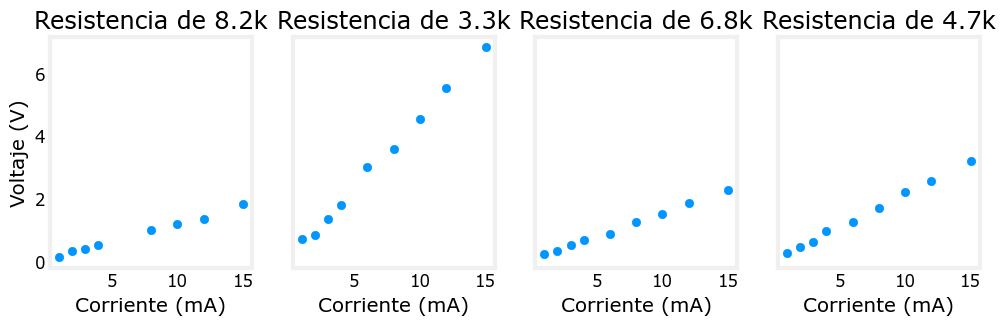

In [40]:
fix,ax = plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for j in range(len(ax)):
    ax[j].scatter(voltajes[j],corrientes[j])
    ax[j].set_xlabel("Corriente (mA)")
    ax[j].set_title("Resistencia de " + str(resistencias_teoricas[j]) + "k")
ax[0].set_ylabel("Voltaje (V)")
plt.show()

## 2da parte

Para la segunda parte del laboratorio se realizaron pruebas con diversas acomodaciones de resitencias para el cálculo indirecto de la resistencia total que generaban a partir de su corriente y voltaje. La resistencias utilizadas fueron de 560Ω, 3.3kΩ, 8.2kΩ, y 4.7kΩ.

- Para el primer experimento se utilizaron las resistencias de 3.3kΩ y 4.7kΩ en serie para dar una resistencia total de 8.0kΩ
- Para el segundo experimento se utilizaron las resistencias de 3.3kΩ, 4.7kΩ y 560Ω en serie para dar una resistencia total de 8.560kΩ
- Para el tercer experimento se utilizaron las resistencias de 3.3kΩ y 4.7kΩ en paralelo para dar una resistecia total de 1.94kΩ
- Para el cuarto experimento se utilizaron las resistencias de 3.3kΩ, 4.7kΩ y 560Ω en paralelo para dar una resistencia total de 434.5Ω
- Para el quinto y último experimento se utilizaron las resistencias de 3.3kΩ y 4.7kΩ en paralelo y unidas a una resistencia en serie de 560Ω, para dar una resistencia total de 2.5kΩ

In [41]:
segundas_resistencias_teoricas = [
  8.000,
  8.560,
  1.940,
  0.434,
  2.500,
]

segundos_voltajes = [
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),
    np.array([1, 2, 3, 4, 5, 6, 7, 8]),
]

segundas_corrientes = [
    np.array([0.124, 0.248, 0.369, 0.492, 0.610, 0.743, 0.860, 0.984]),
    np.array([0.113, 0.227, 0.346, 0.455, 0.570, 0.687, 0.798, 0.918]),
    np.array([0.493, 0.960, 1.468, 2.030, 2.520, 3.010, 3.480, 4.020]),
    np.array([2.120, 4.400, 6.500, 8.680, 10.77, 13.04, 15.24, 17.46]),
    np.array([0.40, 0.78, 1.19, 1.57, 1.96, 2.39, 2.78, 3.14])
]

In [42]:
for k in range(5):
    # initialize parameters
    initial_w = 0.
    initial_b = 0.
    # some gradient descent settings
    iterations = 100000
    alpha = 5.0e-5
    # run gradient descent
    X_train = segundos_voltajes[k]
    y_train = segundas_corrientes[k]
    x_final, b_final, J_hist2 = gradient_descent(X_train, y_train, initial_w, initial_b, compute_cost, compute_gradient, alpha, iterations)
    print(f"w, b encontrados por el gradiente creciente: {x_final:0.4f}, {b_final} ")
    m = X_train.shape[0]
    for i in range(m):
        print(f"Predicción: {np.dot(X_train[i], x_final) + b_final:0.6f}, valor esperado: {y_train[i]}")
    res_exp = 1/x_final
    print(f"Por lo tanto la resistencia teórica de {segundas_resistencias_teoricas[k]}k equivale a {res_exp:0.2f}k")
    print(f"Su error relativo es {(abs((segundas_resistencias_teoricas[k]-round(res_exp, 3))/segundas_resistencias_teoricas[k])*100):0.2f}%\n\n")

Iteration    0: Cost   0.1929
Iteration 10000: Cost   0.0021
Iteration 20000: Cost   0.0000
Iteration 30000: Cost   0.0000
Iteration 40000: Cost   0.0000
Iteration 50000: Cost   0.0000
Iteration 60000: Cost   0.0000
Iteration 70000: Cost   0.0000
Iteration 80000: Cost   0.0000
Iteration 90000: Cost   0.0000
w, b encontrados por el gradiente creciente: 0.1231, 0.0 
Predicción: 0.123056, valor esperado: 0.124
Predicción: 0.246111, valor esperado: 0.248
Predicción: 0.369167, valor esperado: 0.369
Predicción: 0.492222, valor esperado: 0.492
Predicción: 0.615278, valor esperado: 0.61
Predicción: 0.738333, valor esperado: 0.743
Predicción: 0.861389, valor esperado: 0.86
Predicción: 0.984444, valor esperado: 0.984
Por lo tanto la resistencia teórica de 8.0k equivale a 8.13k
Su error relativo es 1.57%


Iteration    0: Cost   0.1666
Iteration 10000: Cost   0.0019
Iteration 20000: Cost   0.0000
Iteration 30000: Cost   0.0000
Iteration 40000: Cost   0.0000
Iteration 50000: Cost   0.0000
Iteratio